In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
from pathlib import Path
import re

In [2]:
patient_df = pd.read_csv('../data/patient_summary.csv')

In [3]:
patient_df.head()

,pid,first_visit_date,last_visit_date,index_date,span_days,encounter_count_total,encounter_count_12m,visits_per_year,sbp_latest,dbp_latest,...,thyroid_ultrasound_count,thyroid_ultrasound_last_date,bp_stage,bmi_class,age_bracket,sbp_missing,dbp_missing,bmi_missing,pulse_missing,age_missing
0,0022a311df715e9740427755bbc194533776e03242c47b...,2024-08-16 09:49:24+02:00,2024-08-16 09:49:24+02:00,2024-08-16 09:49:24+02:00,0,1,1,1.00,109.0,76.0,...,0,NaN,Normal,Normal,25-40,0,0,0,0,0
1,00343c575db967dc335a85dab4ede661c58786aa3180df...,2023-08-15 10:51:17+02:00,2025-10-03 09:10:15+02:00,2025-10-03 09:10:15+02:00,779,3,2,1.41,141.0,74.0,...,0,NaN,Stage-2,Overweight,40-59,0,0,0,0,0
2,003d1426b37bb9341ba25c89156fee5ff70b6e0d402b36...,2025-04-02 09:51:05+02:00,2025-06-12 05:07:40+02:00,2025-06-12 05:07:40+02:00,70,10,10,52.18,126.0,83.0,...,0,NaN,Stage-1,Obesity I,25-40,0,0,0,0,0
3,0045f4e1273379f7d0161bc42ce8f9028bdc7e7fa46581...,2023-08-07 13:09:16+02:00,2025-06-12 10:45:51+02:00,2025-06-12 10:45:51+02:00,674,14,8,7.59,116.0,78.0,...,0,NaN,Normal,Overweight,40-59,0,0,0,0,0
4,0048df6b40355e471b46ee1232b2d01c10c764a2be52fd...,2023-08-09 12:12:50+02:00,2025-10-13 08:38:59+02:00,2025-10-13 08:38:59+02:00,795,10,6,4.59,150.0,100.0,...,0,NaN,Stage-2,Obesity II+,40-59,0,0,0,0,0


In [4]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6356 entries, 0 to 6355
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pid                           6356 non-null   object 
 1   first_visit_date              6356 non-null   object 
 2   last_visit_date               6356 non-null   object 
 3   index_date                    6356 non-null   object 
 4   span_days                     6356 non-null   int64  
 5   encounter_count_total         6356 non-null   int64  
 6   encounter_count_12m           6356 non-null   int64  
 7   visits_per_year               6356 non-null   float64
 8   sbp_latest                    4003 non-null   float64
 9   dbp_latest                    3982 non-null   float64
 10  pulse_latest                  3886 non-null   float64
 11  bmi_latest                    3924 non-null   float64
 12  height_cm_latest              3926 non-null   float64
 13  wei

Top 10 ICD-3 codes by patient count:
primary_icd3
U99    1176
Z13     597
I10     523
Z01     427
E07     390
K76     278
E78     223
Z02     133
N28     106
I70     101
Name: count, dtype: int64

Total number of unique ICD-3 codes: 400

Visualization saved to: ../outputs/visualizations/eda/top10_icd3_patient_count.png


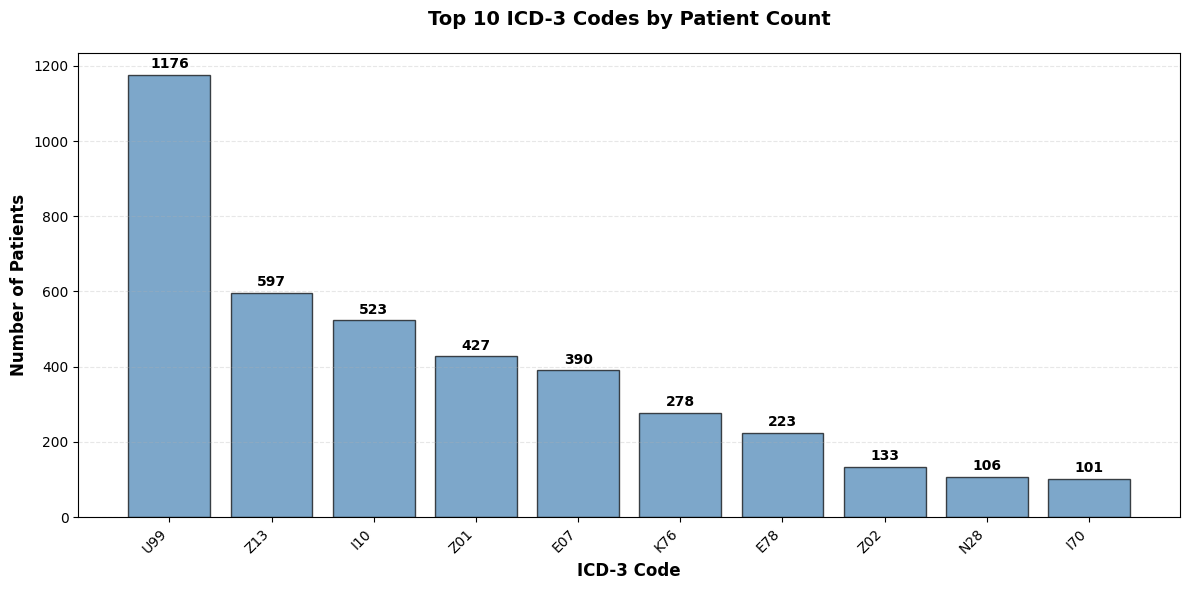

In [9]:
# EDA: Number of patients by ICD-3 code
# Count patients by primary_icd3
icd3_patient_counts = patient_df['primary_icd3'].value_counts()

# Get top 10 ICD-3 codes with most patients
top10_icd3 = icd3_patient_counts.head(10)

print("Top 10 ICD-3 codes by patient count:")
print(top10_icd3)
print(f"\nTotal number of unique ICD-3 codes: {len(icd3_patient_counts)}")

# Create visualization
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(top10_icd3)), top10_icd3.values, color='steelblue', edgecolor='black', alpha=0.7)
plt.xlabel('ICD-3 Code', fontsize=12, fontweight='bold')
plt.ylabel('Number of Patients', fontsize=12, fontweight='bold')
plt.title('Top 10 ICD-3 Codes by Patient Count', fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(top10_icd3)), top10_icd3.index, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, top10_icd3.values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             str(value), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()

# Save the visualization
eda_dir = Path('../outputs/visualizations/eda')
eda_dir.mkdir(parents=True, exist_ok=True)

output_path = eda_dir / 'top10_icd3_patient_count.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved to: {output_path}")

plt.show()


In [6]:
# Add multimorbidity_flag column
# 1 if icd3_count >= 3, else 0
patient_df['multimorbidity_flag'] = (patient_df['icd3_count'] >= 3).astype(int)


Creating boxplots for 27 numeric columns...
Columns: span_days, encounter_count_total, encounter_count_12m, visits_per_year, sbp_latest, dbp_latest, pulse_latest, bmi_latest, height_cm_latest, weight_kg_latest, sbp_baseline, dbp_baseline, pulse_baseline, bmi_baseline, sbp_delta, dbp_delta, pulse_delta, bmi_delta, age, icd3_count, thyroid_ultrasound_count, thyroid_ultrasound_last_date, sbp_missing, dbp_missing, bmi_missing, pulse_missing, age_missing



ZeroDivisionError: division by zero

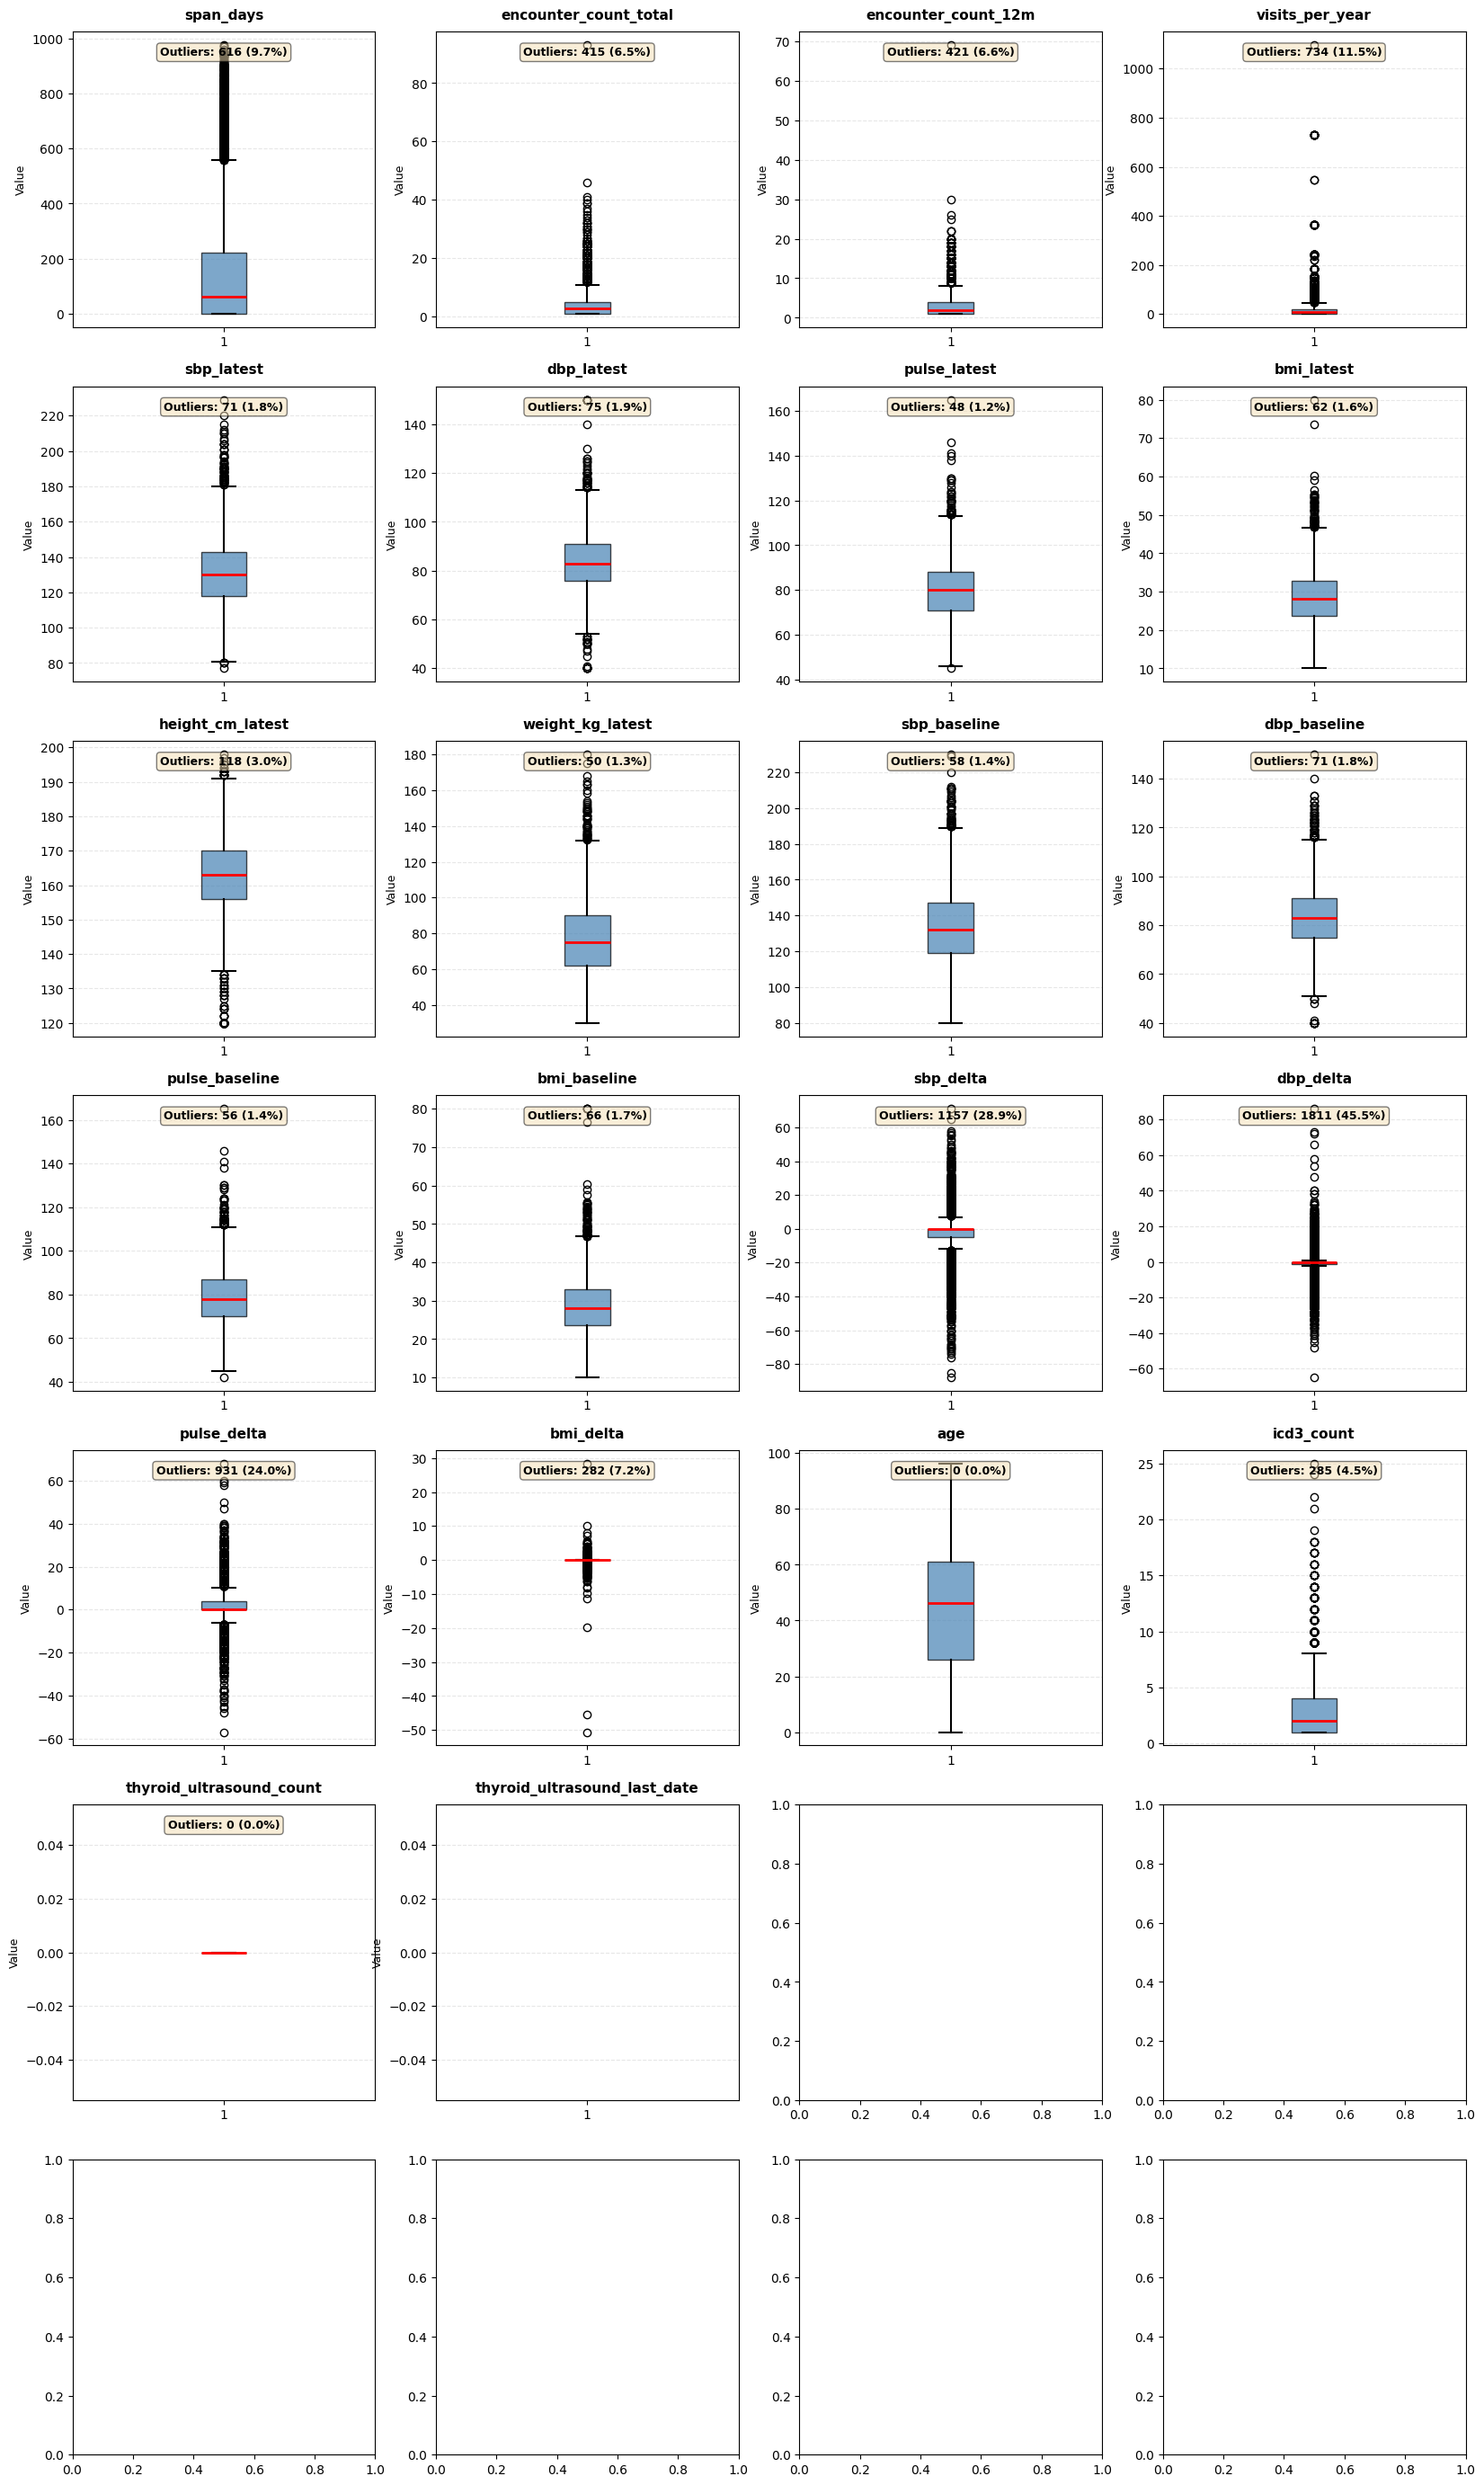

In [10]:
# Boxplots for all numeric fields to check for outliers
# Get all numeric columns
numeric_cols = patient_df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude binary flags from boxplots (they're not useful for outlier detection)
exclude_cols = ['multimorbidity_flag', 'thyroid_ultrasound_done']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

print(f"Creating boxplots for {len(numeric_cols)} numeric columns...")
print(f"Columns: {', '.join(numeric_cols)}\n")

# Calculate grid dimensions
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Create figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

# Create boxplots for each numeric column
for idx, col in enumerate(numeric_cols):
    ax = axes[idx]
    data = patient_df[col].dropna()
    
    # Create boxplot
    bp = ax.boxplot(data, vert=True, patch_artist=True, 
                    boxprops=dict(facecolor='steelblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(color='black', linewidth=1.5),
                    capprops=dict(color='black', linewidth=1.5))
    
    ax.set_title(col, fontsize=11, fontweight='bold', pad=10)
    ax.set_ylabel('Value', fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Calculate and display outlier count
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_count = len(outliers)
    
    # Add outlier count as text
    ax.text(0.5, 0.95, f'Outliers: {outlier_count} ({outlier_count/len(data)*100:.1f}%)',
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9, fontweight='bold')

# Hide unused subplots
for idx in range(len(numeric_cols), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Boxplots for All Numeric Fields - Outlier Detection', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])

# Save the visualization
eda_dir = Path('../outputs/visualizations/eda')
eda_dir.mkdir(parents=True, exist_ok=True)

output_path = eda_dir / 'numeric_fields_boxplots.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nVisualization saved to: {output_path}")

plt.show()

# Print summary statistics for columns with outliers
print("\n" + "="*80)
print("OUTLIER SUMMARY")
print("="*80)
for col in numeric_cols:
    data = patient_df[col].dropna()
    if len(data) > 0:
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        outlier_count = len(outliers)
        
        if outlier_count > 0:
            print(f"\n{col}:")
            print(f"  Total values: {len(data)}")
            print(f"  Outliers: {outlier_count} ({outlier_count/len(data)*100:.2f}%)")
            print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
            print(f"  Min outlier: {outliers.min():.2f}, Max outlier: {outliers.max():.2f}")


In [7]:
patient_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6356 entries, 0 to 6355
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   pid                           6356 non-null   object 
 1   first_visit_date              6356 non-null   object 
 2   last_visit_date               6356 non-null   object 
 3   index_date                    6356 non-null   object 
 4   span_days                     6356 non-null   int64  
 5   encounter_count_total         6356 non-null   int64  
 6   encounter_count_12m           6356 non-null   int64  
 7   visits_per_year               6356 non-null   float64
 8   sbp_latest                    4003 non-null   float64
 9   dbp_latest                    3982 non-null   float64
 10  pulse_latest                  3886 non-null   float64
 11  bmi_latest                    3924 non-null   float64
 12  height_cm_latest              3926 non-null   float64
 13  wei

In [8]:
patient_df.describe()

,span_days,encounter_count_total,encounter_count_12m,visits_per_year,sbp_latest,dbp_latest,pulse_latest,bmi_latest,height_cm_latest,weight_kg_latest,...,icd3_count,thyroid_ultrasound_done,thyroid_ultrasound_count,thyroid_ultrasound_last_date,sbp_missing,dbp_missing,bmi_missing,pulse_missing,age_missing,multimorbidity_flag
count,6356.000000,6356.000000,6356.000000,6356.000000,4003.000000,3982.000000,3886.000000,3924.000000,3926.000000,3974.000000,...,6356.000000,6356.0,6356.0,0.0,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000,6356.000000
mean,162.387351,4.168345,3.405444,22.285308,131.577817,83.448769,80.370304,28.645014,162.544014,76.319112,...,3.031466,0.0,0.0,NaN,0.370201,0.373505,0.382631,0.388609,0.000157,0.439899
std,226.048425,4.492740,3.053011,58.193955,19.697934,12.276426,13.047129,7.253112,11.618537,22.256745,...,2.542223,0.0,0.0,NaN,0.482896,0.483773,0.486067,0.487473,0.012543,0.496414
min,0.000000,1.000000,1.000000,0.880000,77.000000,40.000000,45.000000,10.023723,120.000000,30.000000,...,1.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,118.000000,76.000000,71.000000,23.670000,156.000000,62.000000,...,1.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,62.000000,3.000000,2.000000,7.610000,130.000000,83.000000,80.000000,28.125000,163.000000,75.000000,...,2.000000,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,223.250000,5.000000,4.000000,19.220000,143.000000,91.000000,88.000000,32.890000,170.000000,90.000000,...,4.000000,0.0,0.0,NaN,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,975.000000,93.000000,69.000000,1095.750000,229.000000,150.000000,165.000000,80.000000,198.000000,180.000000,...,25.000000,0.0,0.0,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
